# Data Pre-processing

In this notebook, we will process and prepare the data for input to our model.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

C:\Users\deric\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
data_dir = 'data'

fig_dir = 'fig'

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'vehicles_concat.csv'))

df

,price,model,condition,fuel,odometer,transmission,size,type,paint_color
0,24895.0,jeep-cherokee,other,gas,6973.0,automatic,other,SUV,white
1,12999.0,nissan-altima,other,gas,63810.0,other,other,sedan,other
2,12799.0,hyundai-elantra,other,gas,80210.0,automatic,other,sedan,silver
3,17850.0,ford-f150,other,gas,76393.0,automatic,other,other,white
4,24150.0,dodge-challenger,other,gas,74540.0,automatic,other,coupe,white
...,...,...,...,...,...,...,...,...,...
103665,33064.0,ram-1500,other,gas,42920.0,automatic,other,other,black
103666,27987.0,toyota-tacoma,other,other,44444.0,automatic,other,other,other
103667,32663.0,chevrolet-traverse,other,gas,18498.0,automatic,other,SUV,silver
103668,22986.0,chevrolet-equinox,other,gas,21598.0,automatic,other,SUV,white


## One-hot encoding

Our dataset has a lot of nominal features that needs encoding in order for the data to be fed to the model we will build. We will use the function below, _one_hot_encode_ to encode these features.

In [4]:
def one_hot_encode(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    
    df = pd.concat([df, dummies], axis=1)
    
    return df

We will also drop the columns after encoding them. All except the car model feature which is essential to solving the car model distribution imbalance.

In [5]:
encoded_df = df.copy()

features = ['transmission', 'paint_color', 'fuel', 'condition', 'size', 'type', 'model']

for feature in features:
    encoded_df = one_hot_encode(encoded_df, feature)
    
encoded_df = encoded_df.drop(columns=features[:-1]) # Drop everything except the model feature

In [6]:
encoded_df.to_csv(os.path.join(data_dir, 'vehicles_encoded.csv'), index=False)

## Dataset splitting

Here, we manually split the data set into a train, validation, and test set. We will use 50% of the data for the train set, 25% for validation set, and the remaining 25% for the test set.

In [7]:
import math

split_idx = math.ceil(len(df) / 2)

train_data, test_data = encoded_df[:split_idx], encoded_df[split_idx:]

split_idx = math.ceil(len(test_data) / 2)

valid_data, test_data = test_data[:split_idx], test_data[split_idx:]

train_data.shape, valid_data.shape, test_data.shape

((51835, 295), (25918, 295), (25917, 295))

## Train dataset sampling

If we plot the distribution of the car model feature in the train dataset, we can see that there is a clear imbalance as the plot is skewed. This means that when fed as training dataset to our model, this data might cause our model to become biased towards the car models with high occurrences.

We can improve the distribution through oversampling and undersampling the dataset around the car model feature.

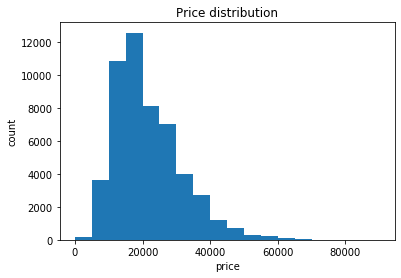

In [10]:
bin_edges = np.arange(0, train_data['price'].max()+5000, 5000)
plt.hist(x=train_data['price'], bins=bin_edges)
plt.ylabel('count')
plt.xlabel('price')
plt.title('Price distribution')
plt.savefig(os.path.join(fig_dir, 'train_price_distribution.jpg'))

### SMOTE

We will use an algorithm called SMOTE(Synthetic Minority Over-sampling Technique) to handle the oversampling of data. You can read more about it here https://medium.com/towards-artificial-intelligence/application-of-synthetic-minority-over-sampling-technique-smote-for-imbalanced-data-sets-509ab55cfdaf. In order for this algorithm to work, all samples in the dataset must have at least 1 neighbor(same car model class). In our case, I decided on at least 6 neighbors so I am taking out any row that has less than that.

In [11]:
train_model_counts = train_data['model'].value_counts()
train_model_counts = train_model_counts[train_model_counts > 5]

train_data = train_data[train_data['model'].isin(train_model_counts.index)]

train_model_counts

ford-f150             3008
ram-1500              2353
nissan-altima         1130
ram-2500              1045
ford-escape           1006
                      ... 
chevrolet-1500          13
ford-cmax               10
lexus-gs                 9
chevrolet-3500           6
mercedes-benz-e350       6
Name: model, Length: 222, dtype: int64

### Edited Nearest Neighbor

For the undersampling, we will use the Edited Nearest Neighbor(ENN) algorithm. It is described as one of the methods available for undersampling here https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/.

We will use the package _imbalanced-learn_ which has already implement SMOTE and ENN into a combined function SMOTEENN. It accepts the features and labels as separate parameters so we will separate them into variables _X_ and _y_.

In [12]:
y = train_data['model']
X = train_data.drop(columns='model')

In [13]:
# from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

X_resampled, y_resampled = SMOTEENN().fit_sample(X,y)

We reassemble the dataframe and add the car model feature back as a column.

In [15]:
resampled_df = X_resampled.copy()

resampled_df['model'] = y_resampled

resampled_df

,price,odometer,transmission_automatic,transmission_manual,transmission_other,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,...,model_volkswagen-beetle,model_volkswagen-golf,model_volkswagen-gti,model_volkswagen-jetta,model_volkswagen-passat,model_volkswagen-tiguan,model_volvo-s60,model_volvo-xc60,model_volvo-xc90,model
0,15367.000000,74455.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
1,15367.000000,74455.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
2,15367.000000,74455.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
3,18400.000000,16401.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
4,15367.000000,74455.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,acura-ilx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274014,45131.080137,1146.374599,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
274015,61019.000000,18133.000000,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
274016,32998.000000,58313.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90
274017,45782.464814,1330.065077,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,volvo-xc90


After sampling, when we plot the distribution of price, we see that the plot is still skewed but with a slightly longer tail. But what is important here is that the distribution of price is not so far from each other anymore. If we take a look at the y-labels of the graph, it can be observed that the higher occurrence car models have been drastically lessened and the lesser occurrence car models, vice-versa.

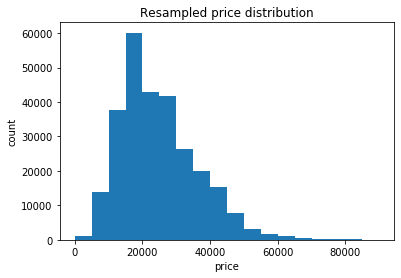

In [16]:
plt.hist(x=resampled_df['price'], bins=bin_edges)
plt.ylabel('count')
plt.xlabel('price')
plt.title('Resampled price distribution')
plt.savefig(os.path.join(fig_dir, 'resampled_train_price_distribution.jpg'))

In [17]:
resampled_df.to_csv(os.path.join(data_dir, 'vechiles_train_resampled.csv'), index=False)

We can now drop the car model feature from the three datasets, note that this feature has already been one-hot encoded earlier.

In [18]:
train_data = resampled_df.drop(columns='model')
valid_data = valid_data.drop(columns='model')
test_data = test_data.drop(columns='model')

Resampling the train dataset has caused its rows to be sorted based on the car model, this cannot be great for when we train our model so we shuffle the train data manually.

In [19]:
train_data = train_data.sample(frac=1)

train_data

,price,odometer,transmission_automatic,transmission_manual,transmission_other,paint_color_black,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,...,model_volkswagen-atlas,model_volkswagen-beetle,model_volkswagen-golf,model_volkswagen-gti,model_volkswagen-jetta,model_volkswagen-passat,model_volkswagen-tiguan,model_volvo-s60,model_volvo-xc60,model_volvo-xc90
144621,18239.573146,11029.409713,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82557,13111.472318,41951.651651,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18086,16895.000000,67103.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154948,11988.000000,99089.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224702,24300.000000,38991.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228958,10480.000000,56646.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96570,48998.000000,63893.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219429,14986.284954,16860.123515,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37979,44278.050509,51424.901166,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We are now done with preprocessing the data and can save the three datasets into CSVs to be fed to the model we are building.

In [20]:
y_test = pd.DataFrame(test_data['price'])
X_test = test_data.drop(columns='price')

y_train = pd.DataFrame(train_data['price'])
X_train = train_data.drop(columns='price')

y_valid = pd.DataFrame(valid_data['price'])
X_valid = valid_data.drop(columns='price')

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(274019, 293)
(25918, 293)
(25917, 293)


In [62]:
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
y_test.to_csv(os.path.join(data_dir, 'test_y.csv'), header=False, index=False)

pd.concat([y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([y_valid, X_valid], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

## What's next
On the next notebooks, we will use the preprocessed data to build three types of models:
1. Amazon SageMaker's LinearLearner
2. Amazon SageMaker's XGBoost
3. Custom PyTorch model